### Random Forest Regression Model with Optuna Bayesian Search and KFold

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import optuna
import shap
from lime.lime_tabular import LimeTabularExplainer
from IPython.display import HTML, display

/Users/amalshar/miniforge3/envs/mlenv64/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('/Users/amalshar/Desktop/USD/Fall 2025/Data Analysis/Final Project/daily_2025_cleaned_data.csv')

In [3]:
X = df[['CO', 'SO2', 'NO2', 'O3', 'PM25',
        'BarometricPressure', 'Temperature', 'WindResultant']]
y = df['DailyAQI']

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [5]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 600),
        'max_depth': trial.suggest_int('max_depth', 5, 50),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),
        'max_features': trial.suggest_categorical('max_features', [None, 'sqrt', 'log2']),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
    }

    # K-Fold Cross Validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = []

    for train_index, val_index in kf.split(X_train):
        X_tr, X_val = X_train.iloc[train_index], X_train.iloc[val_index]
        y_tr, y_val = y_train.iloc[train_index], y_train.iloc[val_index]

        model = RandomForestRegressor(**params, random_state=42, n_jobs=-1)
        model.fit(X_tr, y_tr)
        preds = model.predict(X_val)
        cv_scores.append(r2_score(y_val, preds))

    return np.mean(cv_scores)


In [6]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

[I 2025-11-01 19:53:15,453] A new study created in memory with name: no-name-dc48fdc1-e41f-4988-9aa5-d396191b218e
[I 2025-11-01 19:53:37,401] Trial 0 finished with value: 0.6257944383038866 and parameters: {'n_estimators': 600, 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_features': 'log2', 'bootstrap': False}. Best is trial 0 with value: 0.6257944383038866.
[I 2025-11-01 19:54:07,039] Trial 1 finished with value: 0.8275843629125641 and parameters: {'n_estimators': 498, 'max_depth': 43, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'log2', 'bootstrap': True}. Best is trial 1 with value: 0.8275843629125641.
[I 2025-11-01 19:54:31,494] Trial 2 finished with value: 0.8165642809556903 and parameters: {'n_estimators': 199, 'max_depth': 16, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': None, 'bootstrap': True}. Best is trial 1 with value: 0.8275843629125641.
[I 2025-11-01 19:55:46,270] Trial 3 finished with value: 0.8687564314086341 a

In [7]:
print("Best Hyperparameters:", study.best_params)

Best Hyperparameters: {'n_estimators': 264, 'max_depth': 50, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'bootstrap': False}


In [8]:
# Train Best Model
best_params = study.best_params
best_rf_model = RandomForestRegressor(**best_params, random_state=42, n_jobs=-1)
best_rf_model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=False, max_depth=50, max_features='sqrt',
                      min_samples_split=3, n_estimators=264, n_jobs=-1,
                      random_state=42)

In [9]:
# Test Set Evaluation
y_pred = best_rf_model.predict(X_test)

In [10]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
r2 = r2_score(y_test, y_pred)

print(f"\nTest Set Evaluation:")
print(f"Mean Squared Error (MSE): {mse:.3f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.3f}")
print(f"Mean Absolute Error (MAE): {mae:.3f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"R-squared (R²): {r2:.3f}")


Test Set Evaluation:
Mean Squared Error (MSE): 132.927
Root Mean Squared Error (RMSE): 11.529
Mean Absolute Error (MAE): 2.974
Mean Absolute Percentage Error (MAPE): inf%
R-squared (R²): 0.875


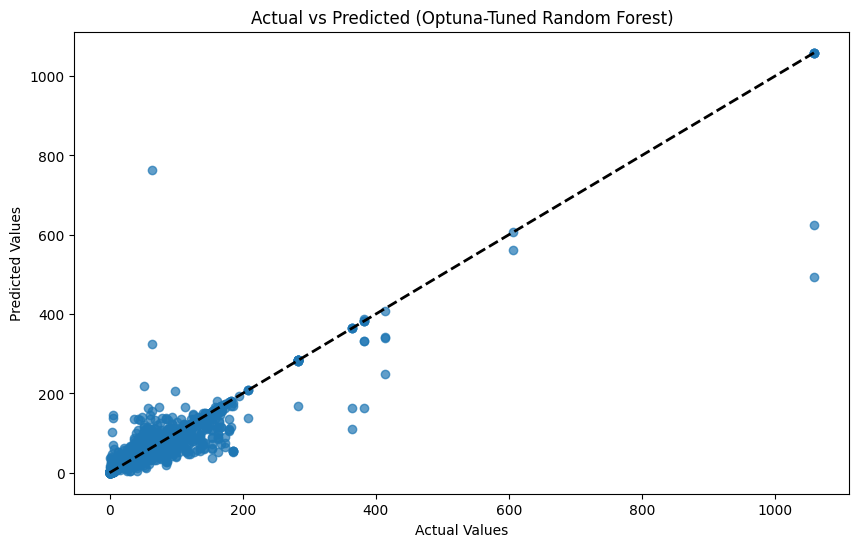

In [11]:
# Actual vs Predicted Plot
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted (Optuna-Tuned Random Forest)")
plt.show()

In [12]:
# Feature Importance
importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': best_rf_model.feature_importances_
})
importances = importances.sort_values(by='Importance', ascending=False)
print("\nFeature Importance (Random Forest):")
print(importances)


Feature Importance (Random Forest):
              Feature  Importance
4                PM25    0.369126
3                  O3    0.126323
6         Temperature    0.125833
2                 NO2    0.113928
5  BarometricPressure    0.073178
0                  CO    0.072442
7       WindResultant    0.065829
1                 SO2    0.053341


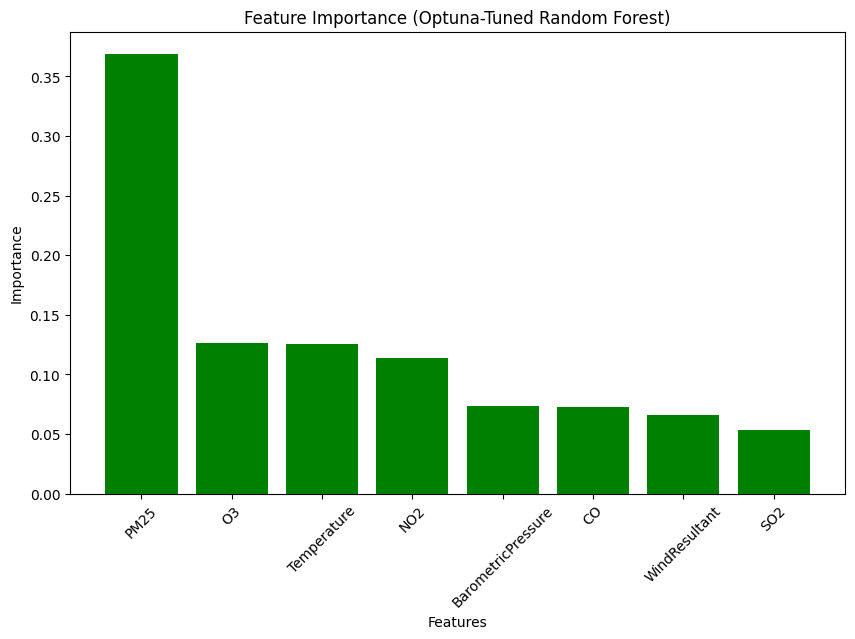

In [13]:
# Plot Feature Importance
plt.figure(figsize=(10,6))
plt.bar(importances['Feature'], importances['Importance'], color='green')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance (Optuna-Tuned Random Forest)')
plt.xticks(rotation=45)
plt.show()

In [14]:
# SHAP Explainability
explainer = shap.TreeExplainer(best_rf_model)
shap_values = explainer.shap_values(X_test)

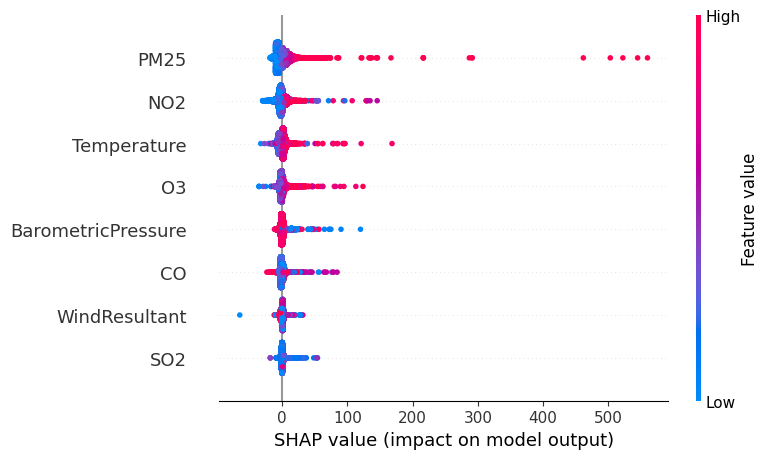

In [15]:
# SHAP Summary Plot
shap.summary_plot(shap_values, X_test)

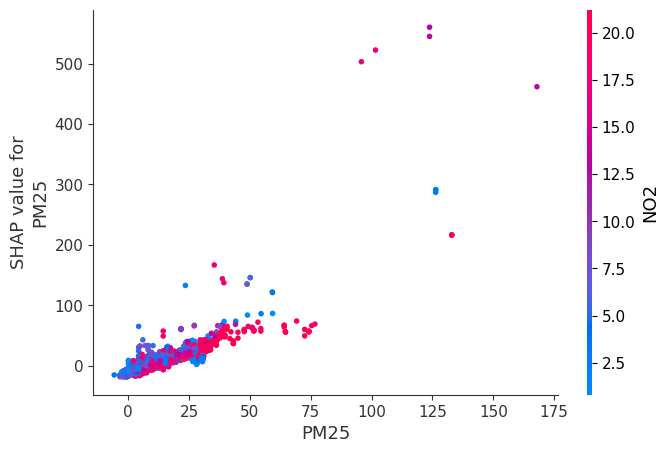

In [16]:
# SHAP Dependence Plot
shap.dependence_plot('PM25', shap_values, X_test)

In [17]:
# LIME Explainability
lime_explainer = LimeTabularExplainer(
    X_train.values,
    feature_names=X.columns.tolist(),
    class_names=['DailyAQI'],
    mode='regression'
)

i = 0  # Example index to explain
exp = lime_explainer.explain_instance(
    X_test.values[i],
    best_rf_model.predict,
    num_features=5
)

# Instead of show_in_notebook (which may break):
html_output = exp.as_html()

# Save HTML for viewing or submission
with open("exp5_lime_explanation.html", "w") as f:
    f.write(html_output)

# Render in notebook safely
display(HTML(html_output))

/Users/amalshar/miniforge3/envs/mlenv64/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [18]:
# Print explanation
print("\nLIME Explanation:")
for feature, weight in exp.as_list():
    print(f"{feature}: {weight}")

# Save the explanation as HTML
html_output = exp.as_html()
with open("exp5_lime_explanation.html", "w") as f:
    f.write(html_output)


LIME Explanation:
3.49 < PM25 <= 6.00: -8.177684899652602
2.21 < NO2 <= 5.53: -5.174716485103278
0.17 < CO <= 0.20: -2.5042988151474166
BarometricPressure > 1007.88: -2.3030049136029564
44.08 < Temperature <= 48.73: 2.137800892745988


In [19]:
# Style for notebook display
styled_html = f"""
<div style="background-color: white; padding: 20px; border: 1px solid black; border-radius: 5px;">
    {html_output}
</div>
"""
display(HTML(styled_html))
